In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import heapq
import itertools
import copy
import os
import seaborn as sns
import pandas as pd
from PIL import Image
import time
from tqdm import tqdm
import PIL
import random
import math
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import random
from torchvision.transforms import InterpolationMode

In [2]:
def torch_fix_seed(seed=42):
    # Python random
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Pytorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.use_deterministic_algorithms = True
torch_fix_seed()

In [3]:
# pretrained_model = "reg_H.pth" #事前学習済みMNISTモデル(重みパラメータ)
use_cuda = True

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(57600, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return x
# 使うデバイス（CPUかGPUか）の定義
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")
model_list = []
for i in range(26):
    pretrained_model = "../model/reg_" + chr(i + 65) + ".pth"
    # if i == 0:
    #     pretrained_model = "../model/reg_" + chr(i + 65) + "_gray.pth"
    # ネットワークの初期化
    model = Net().to(device)
    # 訓練済みモデルのロード
    model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))
    # モデルを評価モードに設定。本チュートリアルの例では、これはドロップアウト層等を評価モードにするのに必要
    model.eval()
    model_list.append(model)

CUDA Available:  True


In [5]:
def test(model, device):
    R2_list = []
    for index, model in enumerate(model_list):
        class ImageTransform():
            def __init__(self, mean, std):
                self.data_transform = transforms.Compose([
                transforms.Grayscale(),
                transforms.ToTensor(),
                transforms.Resize((64, 64), interpolation=InterpolationMode.NEAREST),
                transforms.Normalize(mean, std)
                ])

            def __call__(self, img):
                return self.data_transform(img)
        mean = (0.5,)
        std = (0.5,)
        
        alphabet = chr(index + 65)
        images_train = ImageFolder("../data/GoogleFonts/test_reg/" + alphabet, transform = ImageTransform(mean, std))
        batch_size = 1
        dataloader = DataLoader(images_train, batch_size = batch_size, shuffle = True, drop_last=True)

        a = 0
        target_total = []
        output_total = []
        count = 0
        correct = 0
        # テスト用データセット内の全てのサンプルをループします
        for data, target in tqdm(dataloader, total = 200):
            # i+=1
            # if i==150:
            #     break
            # データとラベルをデバイス（CPUもしくはGPU）に送信します
            data, target = data.to(device), target.type(torch.float32).to(device)

            # テンソルの requires_grad 属性を設定します。攻撃者にとっては重要な設定です。
            data.requires_grad = True

            # データをモデルに順伝播させます
            output = model(data)

            # if output.item() >= 4:
            #     count += 1
            #     if target.item() >= 4:
            #         correct += 1

            # plt.xticks([], [])
            # plt.yticks([], [])
            # plt.imsave("../GoogleFonts_reg/reg_result/" + alphabet + chr() + "/{}".format(count) + "/" + "{}.png".format(i), data.squeeze().detach().cpu().numpy(), cmap="gray")
            a += (target.item() - output.item()) ** 2
            target_total.append(target.item())
            output_total.append(output.item())
            # print("{}:{}".format(output.item(), target.item()))
        sum = np.sum(target_total)
        ave = sum / len(target_total)
        b = np.sum(list(map(lambda x: x ** 2, target_total - ave)))
        R2 = 1 - (a / b)
        print(chr(index + 65) + "_R^2:{}".format(R2))
        R2_list.append(R2)
        plt.figure(figsize=(5,5))
        x = np.array([0, 35])
        y = x
        plt.scatter(target_total, output_total, zorder=2)
        plt.plot(x, y, color = "orangered", zorder=1)
        plt.xlim(0, 35)
        plt.ylim(0, 35)
        # plt.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False, bottom=False, left=False, right=False, top=False)
        # plt.savefig("../GoogleFonts_reg/y_y/reg_" + chr(index + 65) + ".png", facecolor="white")
        plt.show()
    df = pd.DataFrame(data=np.array([R2_list]), index=["R^2"], columns=[chr(i + 65) for i in range(26)])
    print(max)
    # df = pd.DataFrame(data=np.array([R2_list]))
    return df

100%|██████████| 200/200 [00:01<00:00, 121.38it/s]


A_R^2:-0.9920635531052684


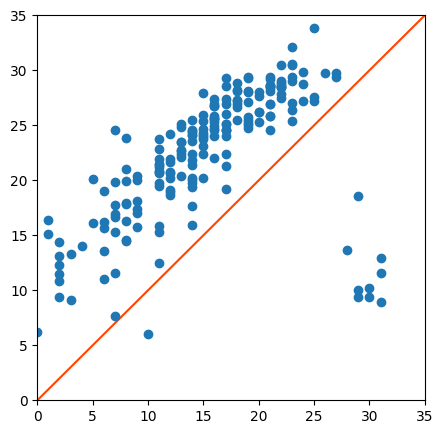

100%|██████████| 200/200 [00:00<00:00, 727.50it/s]


B_R^2:-3.3628189800142625


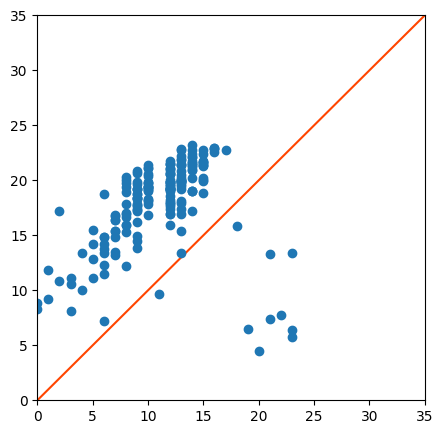

100%|██████████| 200/200 [00:00<00:00, 734.30it/s]


C_R^2:-0.862682411344228


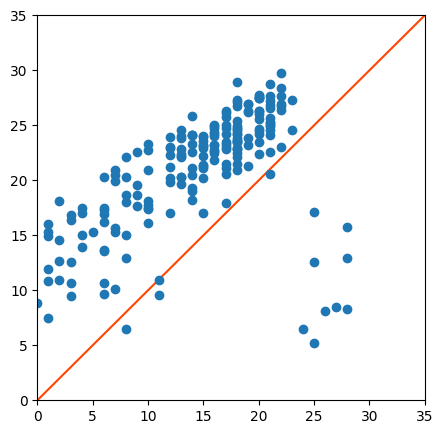

100%|██████████| 200/200 [00:00<00:00, 706.07it/s]


D_R^2:-3.171712345468717


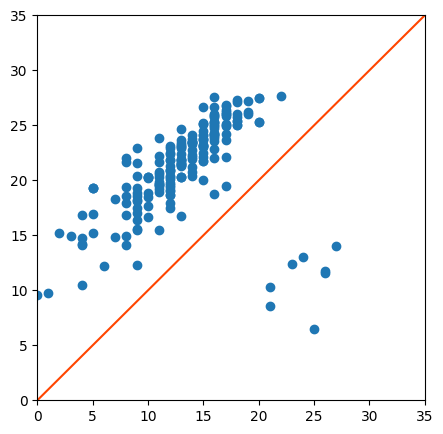

100%|██████████| 200/200 [00:00<00:00, 749.18it/s]


E_R^2:-3.050920541287372


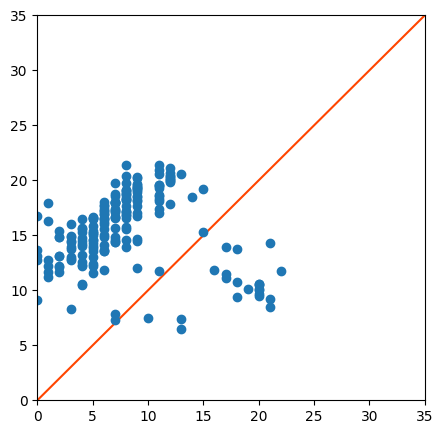

100%|██████████| 200/200 [00:00<00:00, 721.53it/s]


F_R^2:-0.6874234395746264


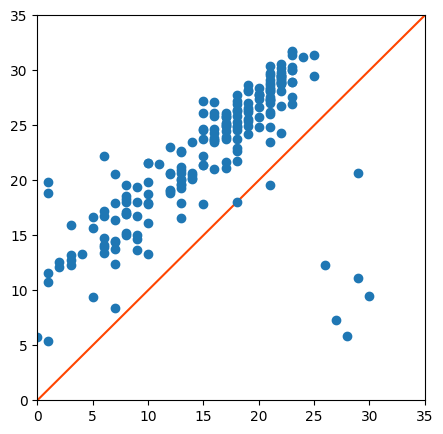

100%|██████████| 200/200 [00:00<00:00, 565.04it/s]


G_R^2:-3.4258417652808983


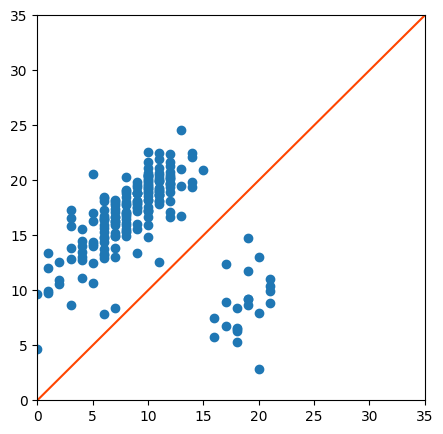

100%|██████████| 200/200 [00:00<00:00, 730.94it/s]


H_R^2:-1.413980900893765


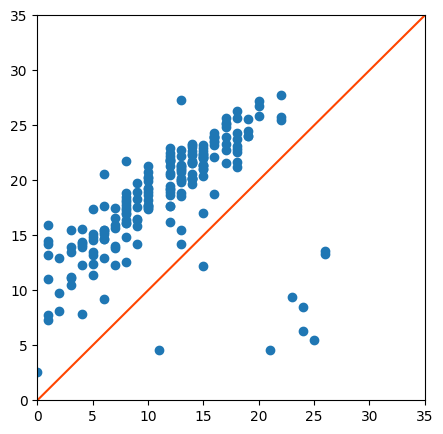

100%|██████████| 200/200 [00:00<00:00, 724.41it/s]


I_R^2:-1.0361239802373885


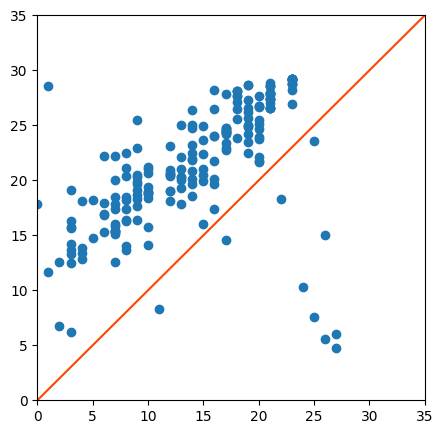

100%|██████████| 200/200 [00:00<00:00, 716.66it/s]


J_R^2:-0.6371666830158658


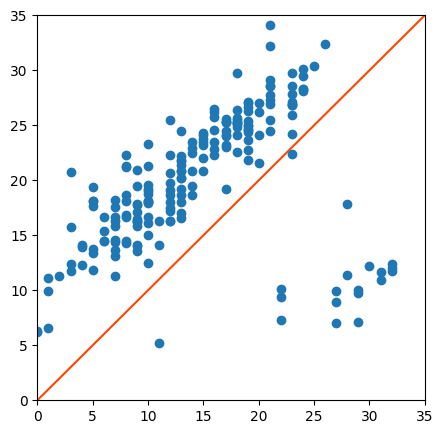

100%|██████████| 200/200 [00:00<00:00, 718.25it/s]


K_R^2:-2.153196715112442


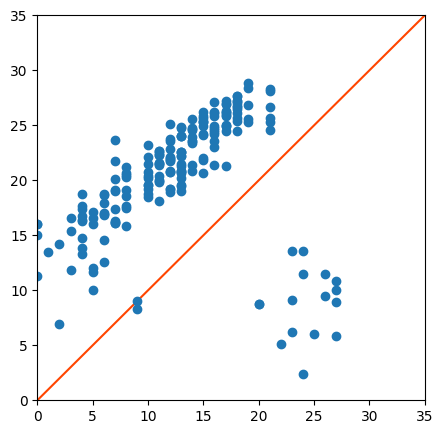

100%|██████████| 200/200 [00:00<00:00, 682.86it/s]


L_R^2:-2.3450804623267723


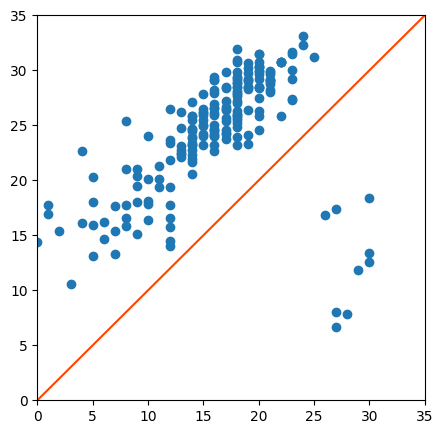

100%|██████████| 200/200 [00:00<00:00, 443.73it/s]


M_R^2:-2.270287925519341


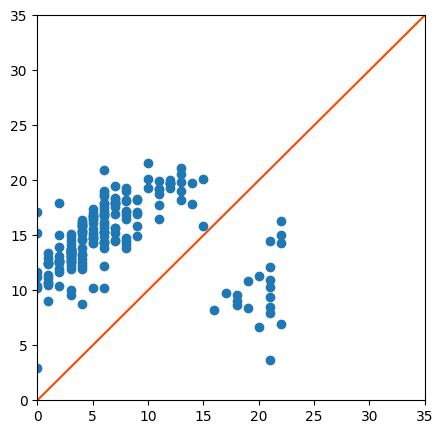

100%|██████████| 200/200 [00:00<00:00, 512.30it/s]


N_R^2:-4.605765345934333


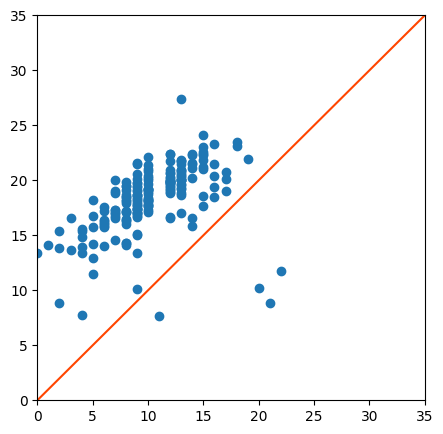

100%|██████████| 200/200 [00:00<00:00, 700.90it/s]


O_R^2:-1.313706425947022


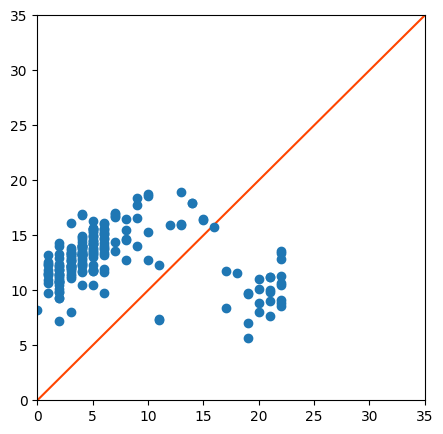

100%|██████████| 200/200 [00:00<00:00, 735.98it/s]


P_R^2:-0.8406772089302426


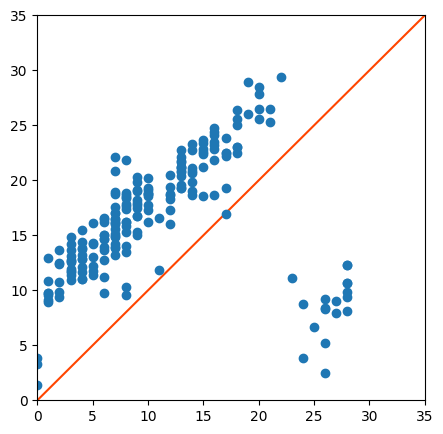

100%|██████████| 200/200 [00:00<00:00, 726.60it/s]


Q_R^2:-1.518561263541204


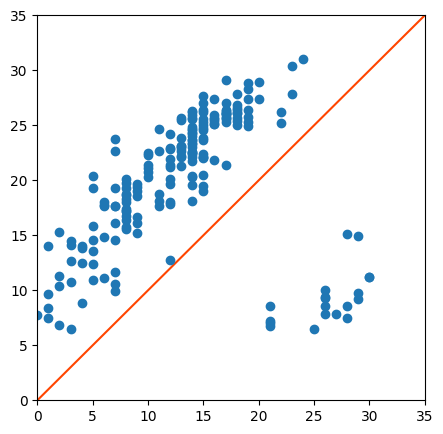

100%|██████████| 200/200 [00:00<00:00, 739.62it/s]


R_R^2:-1.7081552386016465


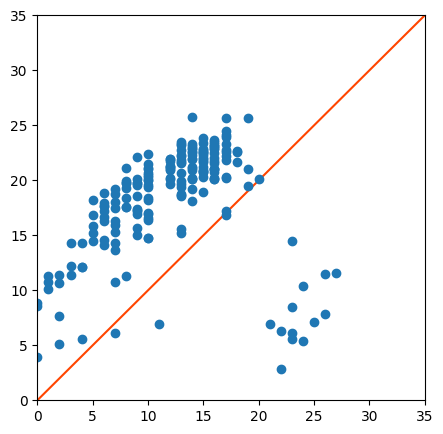

100%|██████████| 200/200 [00:00<00:00, 573.75it/s]


S_R^2:-2.0283851979163647


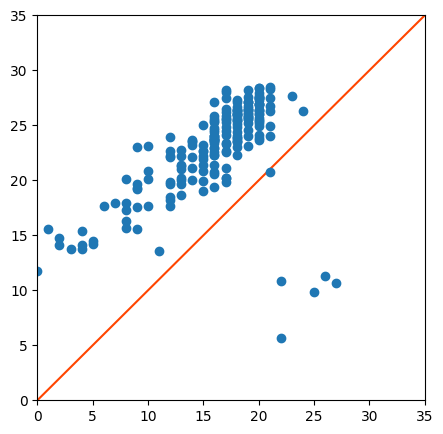

100%|██████████| 200/200 [00:00<00:00, 703.78it/s]


T_R^2:-1.4826332225421992


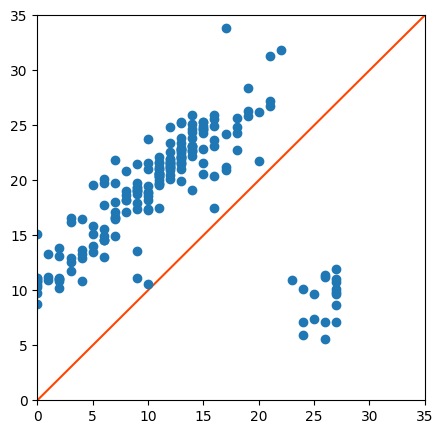

100%|██████████| 200/200 [00:00<00:00, 714.22it/s]


U_R^2:-1.796505259041559


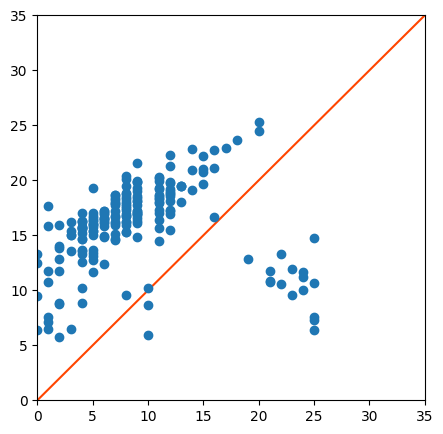

100%|██████████| 200/200 [00:00<00:00, 570.27it/s]


V_R^2:-4.768152923320316


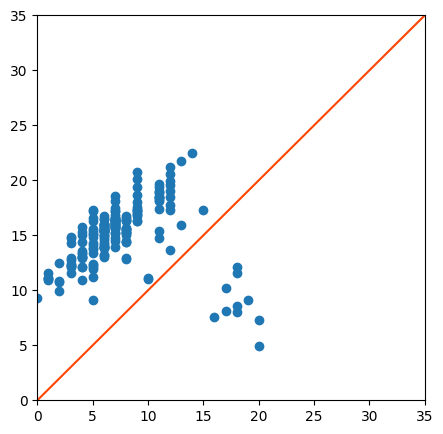

100%|██████████| 200/200 [00:00<00:00, 727.59it/s]


W_R^2:-1.9217326124332041


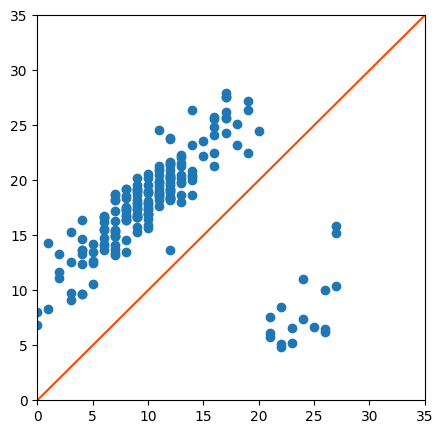

100%|██████████| 200/200 [00:00<00:00, 701.22it/s]


X_R^2:-6.050000383741223


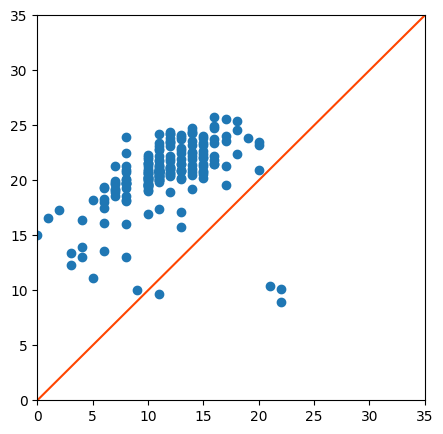

100%|██████████| 200/200 [00:00<00:00, 728.27it/s]


Y_R^2:-1.7026081452364505


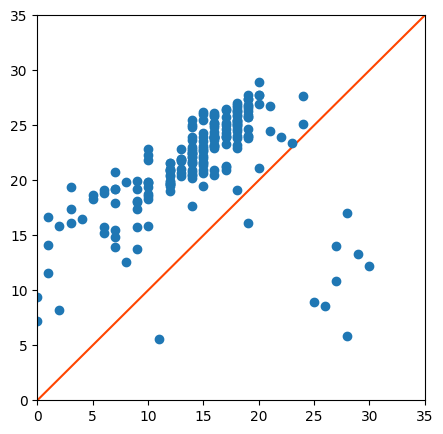

100%|██████████| 200/200 [00:00<00:00, 721.94it/s]


Z_R^2:-1.8919189285815703


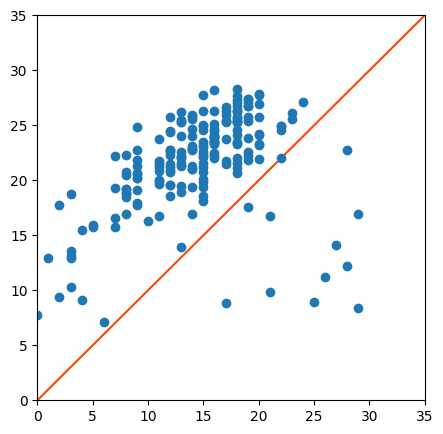

<built-in function max>


In [6]:
accuracies = []
examples = []

# 各epsilonごとにテストを実行
df = test(model, device)

In [7]:
pd.set_option('display.max_columns', 100)
df

,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T,U,V,W,X,Y,Z
R^2,-0.992064,-3.362819,-0.862682,-3.171712,-3.050921,-0.687423,-3.425842,-1.413981,-1.036124,-0.637167,-2.153197,-2.34508,-2.270288,-4.605765,-1.313706,-0.840677,-1.518561,-1.708155,-2.028385,-1.482633,-1.796505,-4.768153,-1.921733,-6.05,-1.702608,-1.891919
